In [2]:
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image
import time  # For profiling

# Paths to YOLO files
weights_path = "yolov3.weights"  # Ensure the file is in the current directory or specify the correct path
config_path = "yolov3.cfg"       # Ensure the file is in the current directory or specify the correct path
names_path = "coco.names"        # Ensure the file is in the current directory or specify the correct path

# Load YOLO
net = cv2.dnn.readNet(weights_path, config_path)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

# Load class names
with open(names_path, "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Define colors for each class
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [3]:
def detect_objects_in_video(video_source=0):
    video_capture = cv2.VideoCapture(video_source)
    
    while True:
        start_time = time.time()  # Start time for profiling
        
        ret, frame = video_capture.read()
        if not ret:
            break
        
        # Prepare the frame for the model
        height, width = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        detections = net.forward(output_layers)
        
        boxes = []
        confidences = []
        class_ids = []
        
        for detection in detections:
            for object in detection:
                scores = object[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:  # Confidence threshold
                    # Object detected
                    center_x = int(object[0] * width)
                    center_y = int(object[1] * height)
                    w = int(object[2] * width)
                    h = int(object[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)
        
        # Apply Non-Maximum Suppression (NMS)
        indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        
        if len(indices) > 0:
            indices = indices.flatten()  # Ensure indices is a flat list

            for i in indices:
                box = boxes[i]
                x, y, w, h = box
                color = colors[class_ids[i]]
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                text = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
                cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Convert frame to RGB and display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame_rgb)
        
        # Display image in notebook
        clear_output(wait=True)
        display(img)
        
        # Calculate and print frame processing time
        end_time = time.time()
        fps = 1 / (end_time - start_time)
        print(f"FPS: {fps:.2f}")
        
        # Use a key press for breaking the loop in the notebook
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
    
    video_capture.release()

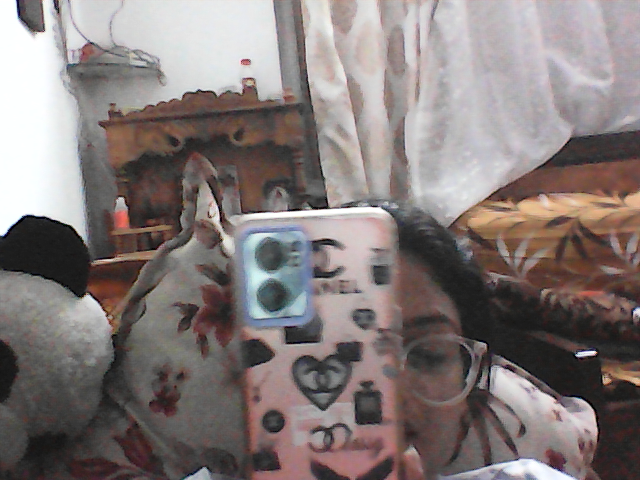

In [ ]:
detect_objects_in_video(video_source=0)  # 0 for webcam; replace with video path for file